In [ ]:
from google.colab import drive

import numpy as np
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim

import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Normalize, Compose

from torch.utils.data import TensorDataset, DataLoader

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/My Drive/100/'
os.chdir(dataset_path)

In [ ]:
!tar -xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
os.listdir('.')

['cifar-10-python.tar.gz', 'cifar-10-batches-py']

In [ ]:
def unpickle(file):
    with open(f'cifar-10-batches-py/{file}', 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [ ]:
train_data = []
train_labels = []

# Load and append all training batches
for i in range(1, 6):
    batch = unpickle(f'data_batch_{i}')
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

# Convert lists to numpy arrays for convenience
train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
train_labels = np.array(train_labels)

# Load the test batch
test_batch = unpickle('test_batch')
test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_labels = np.array(test_batch[b'labels'])

In [ ]:
print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


## DataLoader Task 1

In [ ]:
train_data_tensor = torch.tensor(train_data.transpose((0, 3, 1, 2)), dtype=torch.float) / 255.0
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_data_tensor = torch.tensor(test_data.transpose((0, 3, 1, 2)), dtype=torch.float) / 255.0
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_data_tensor = (train_data_tensor - 0.5) / 0.5
test_data_tensor = (test_data_tensor - 0.5) / 0.5

train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Fetch the first batch from the train_loader
first_batch_inputs, first_batch_labels = next(iter(train_loader))
print(f"Shape of the inputs in the first batch: {first_batch_inputs.shape}")
# Expected output: Shape of the inputs in the first batch: torch.Size([64, 3, 32, 32])


Shape of the inputs in the first batch: torch.Size([64, 3, 32, 32])


Batch images shape: torch.Size([64, 3, 32, 32])
Batch labels shape: torch.Size([64])


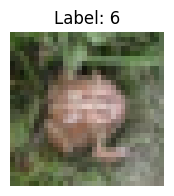

In [ ]:
images, labels = next(iter(train_loader))

print(f"Batch images shape: {images.shape}")
print(f"Batch labels shape: {labels.shape}")

# Visualize the first image in the batch
plt.figure(figsize=(2, 2))
plt.imshow(images[0].permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize
plt.title(f"Label: {labels[0]}")
plt.axis('off')
plt.show()

In [ ]:

# # version 2
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class ImprovedIntermediateBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(ImprovedIntermediateBlock, self).__init__()
#         self.convs = nn.ModuleList([
#             nn.Sequential(
#                 nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(),
#                 nn.Dropout2d(0.2),
#             ),
#             nn.Sequential(
#                 nn.Conv2d(64, 64, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(),
#                 nn.Dropout2d(0.2),
#             ),
#             nn.Sequential(
#                 nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(),
#                 nn.Dropout2d(0.2),
#             )
#         ])
#         self.pool = nn.AdaptiveAvgPool2d((8, 8))

#     def forward(self, x):
#         for conv in self.convs:
#             x = conv(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

# class EnhancedOutputBlock(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super(EnhancedOutputBlock, self).__init__()
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc1 = nn.Linear(in_channels, in_channels // 2)
#         self.fc2 = nn.Linear(in_channels // 2, num_classes)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

# class CIFAR10Classifier(nn.Module):
#     def __init__(self, num_blocks=2, num_classes=10):
#         super(CIFAR10Classifier, self).__init__()
#         self.blocks = nn.ModuleList()
#         in_channels = 3
#         out_channels = 64
#         for i in range(num_blocks):
#             self.blocks.append(ImprovedIntermediateBlock(in_channels, out_channels))
#             in_channels = out_channels
#         self.output_block = EnhancedOutputBlock(out_channels, num_classes)

#     def forward(self, x):
#         for block in self.blocks:
#             x = block(x)
#         x = self.output_block(x)
#         return x

# model = CIFAR10Classifier()
# print(model)


CIFAR10Classifier(
  (blocks): ModuleList(
    (0): ImprovedIntermediateBlock(
      (convs): ModuleList(
        (0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout2d(p=0.2, inplace=False)
        )
        (1-2): 2 x Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout2d(p=0.2, inplace=False)
        )
      )
      (pool): AdaptiveAvgPool2d(output_size=(8, 8))
      (fc): Linear(in_features=4096, out_features=64, bias=True)
    )
    (1): ImprovedIntermediateBlock(
      (convs): ModuleList(
        (0-2): 3 x Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNor

# Model Task 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedIntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImprovedIntermediateBlock, self).__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Dropout2d(0.2),
            ),
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Dropout2d(0.2),
            ),
            nn.Sequential(
                nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Dropout2d(0.2),
            )
        ])
        self.pool = nn.AdaptiveAvgPool2d((8, 8))

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = self.pool(x)
        # Note: Removed flattening and self.fc to preserve 4D output shape
        return x

class EnhancedOutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(EnhancedOutputBlock, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_channels * 1 * 1, in_channels // 2)
        self.fc2 = nn.Linear(in_channels // 2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flattening is appropriate here for FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class CIFAR10Classifier(nn.Module):
    def __init__(self, num_blocks=2, num_classes=10):
        super(CIFAR10Classifier, self).__init__()
        self.blocks = nn.ModuleList()
        in_channels = 3
        out_channels = 64  # Adjust based on the architecture's requirement
        for i in range(num_blocks):
            self.blocks.append(ImprovedIntermediateBlock(in_channels, out_channels))
            in_channels = out_channels
        self.output_block = EnhancedOutputBlock(out_channels, num_classes)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.output_block(x)
        return x

# Model initialization for demonstration
modelb = CIFAR10Classifier()
print(modelb)

CIFAR10Classifier(
  (blocks): ModuleList(
    (0): ImprovedIntermediateBlock(
      (convs): ModuleList(
        (0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout2d(p=0.2, inplace=False)
        )
        (1-2): 2 x Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout2d(p=0.2, inplace=False)
        )
      )
      (pool): AdaptiveAvgPool2d(output_size=(8, 8))
    )
    (1): ImprovedIntermediateBlock(
      (convs): ModuleList(
        (0-2): 3 x Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

# Training Task 3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming CIFAR10Classifier is the class name for Version 2 of the model
modelb = CIFAR10Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelb.parameters(), lr=0.001)

# CIFAR-10 Data Loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Training Loop
num_epochs = 10  # Adjust as per requirement
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = modelb(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

print('Finished Training')


100%|██████████| 170498071/170498071 [00:02<00:00, 63992678.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1, Loss: 1.9201718475812537
Epoch 2, Loss: 1.723445228908373
Epoch 3, Loss: 1.6384051207386319
Epoch 4, Loss: 1.552598842726949
Epoch 5, Loss: 1.487273252071322
Epoch 6, Loss: 1.4366286993026733
Epoch 7, Loss: 1.380320988347768
Epoch 8, Loss: 1.3379279149462804
Epoch 9, Loss: 1.2834130206223948
Epoch 10, Loss: 1.2516043393508247
Finished Training


In [ ]:
modelb.eval()  # Set the model to evaluation mode

correct = 0
total = 0
with torch.no_grad():  # Deactivate gradients for evaluation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelb(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10000 test images: {accuracy} %')


Accuracy of the model on the 10000 test images: 66.85 %


# Testing Task 4


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming CIFAR10Classifier is already defined and ready to be used

# Define your CIFAR10Classifier model
modelb = CIFAR10Classifier().to(device)

# Criterion (Loss function)
criterion = nn.CrossEntropyLoss()

# Optimizer - SGD with learning rate = 0.01 and weight decay = 0.0005
optimizer = optim.SGD(modelb.parameters(), lr=0.01, weight_decay=0.0005)

# CIFAR-10 Data Loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Training Loop
num_epochs = 30  # You might adjust this based on observation
for epoch in range(num_epochs):
    modelb.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = modelb(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print statistics
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Don't forget to evaluate your model on the test set after training
modelb.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # Gradient computation is not needed for evaluation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelb(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10000 test images: {accuracy}%')



Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 2.2499043228071365
Epoch 2, Loss: 2.0759009603039384
Epoch 3, Loss: 1.9689246632558914
Epoch 4, Loss: 1.901074612689445
Epoch 5, Loss: 1.8472076241317612
Epoch 6, Loss: 1.8003965338782582
Epoch 7, Loss: 1.7622349650963494
Epoch 8, Loss: 1.7361485461139923
Epoch 9, Loss: 1.7113205109106
Epoch 10, Loss: 1.6816463346981332
Epoch 11, Loss: 1.6568673065556285
Epoch 12, Loss: 1.6290464712225872
Epoch 13, Loss: 1.611982100302606
Epoch 14, Loss: 1.5897108513071103
Epoch 15, Loss: 1.572034317056846
Epoch 16, Loss: 1.5512201484206998
Epoch 17, Loss: 1.5318830426391739
Epoch 18, Loss: 1.5172591369475246
Epoch 19, Loss: 1.4942419678353898
Epoch 20, Loss: 1.4822416895490778
Epoch 21, Loss: 1.465499476551095
Epoch 22, Loss: 1.4487827263219888
Epoch 23, Loss: 1.4371533383188955
Epoch 24, Loss: 1.4259785709478665
Epoch 25, Loss: 1.40423893943772
Epoch 26, Loss: 1.3962271004686575
Epoch 27, Loss: 1.37749469325975

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming CIFAR10Classifier is already defined and ready to be used

# Define your CIFAR10Classifier model
modelb = CIFAR10Classifier().to(device)

# Criterion (Loss function)
criterion = nn.CrossEntropyLoss()

# Optimizer - SGD with learning rate = 0.01 and weight decay = 0.0005
optimizer = optim.SGD(modelb.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# CIFAR-10 Data Loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Training Loop
num_epochs = 30  # You might adjust this based on observation
for epoch in range(num_epochs):
    modelb.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = modelb(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print statistics
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Don't forget to evaluate your model on the test set after training
modelb.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # Gradient computation is not needed for evaluation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelb(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10000 test images: {accuracy}%')



Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 2.2172538371342223
Epoch 2, Loss: 2.0500300409238967
Epoch 3, Loss: 1.9548271138344884
Epoch 4, Loss: 1.8862769993979607
Epoch 5, Loss: 1.8349451456228485
Epoch 6, Loss: 1.7946608147352858
Epoch 7, Loss: 1.7552768798435436
Epoch 8, Loss: 1.7275069894083321
Epoch 9, Loss: 1.7062956980427209
Epoch 10, Loss: 1.6827622868520828
Epoch 11, Loss: 1.6610377278474286
Epoch 12, Loss: 1.649524820277758
Epoch 13, Loss: 1.6251667161731769
Epoch 14, Loss: 1.6177007185528651
Epoch 15, Loss: 1.5925916966879765
Epoch 16, Loss: 1.574739970362095
Epoch 17, Loss: 1.549618603933193
Epoch 18, Loss: 1.542361816786744
Epoch 19, Loss: 1.5164294659024309
Epoch 20, Loss: 1.49933549647441
Epoch 21, Loss: 1.4879309342950202
Epoch 22, Loss: 1.467726619042399
Epoch 23, Loss: 1.4643865755147032
Epoch 24, Loss: 1.441449738524454
Epoch 25, Loss: 1.4274560534740652
Epoch 26, Loss: 1.4079837039913363
Epoch 27, Loss: 1.3966126135548

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming CIFAR10Classifier is defined within allowed adjustments
modelb = CIFAR10Classifier().to(device)

# Criterion (Loss function)
criterion = nn.CrossEntropyLoss()

# Using ADAM Optimizer
optimizer = optim.Adam(modelb.parameters(), lr=0.001)

# Enhanced Data Augmentation for Task 4
transform_train_task4 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Loading CIFAR-10 Data
trainset_task4 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_task4)
trainloader_task4 = DataLoader(trainset_task4, batch_size=128, shuffle=True)

testset_task4 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader_task4 = DataLoader(testset_task4, batch_size=100, shuffle=False)

# Training Loop
num_epochs = 50  # Increased epochs for more thorough training
best_accuracy = 0  # Track the best testing accuracy

for epoch in range(num_epochs):
    modelb.train()
    running_loss = 0.0
    for images, labels in trainloader_task4:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = modelb(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(trainloader_task4)}')

    # Evaluation on the test set
    modelb.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader_task4:
            images, labels = images.to(device), labels.to(device)
            outputs = modelb(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy after epoch {epoch+1}: {accuracy}%')

    # Save the model if it has the best accuracy so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(modelb.state_dict(), 'best_model.pth')
        print(f"New best model saved with accuracy: {accuracy}%")

print('Finished Training')


NameError: name 'CIFAR10Classifier' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CIFAR10Classifier(nn.Module):
    # Assuming this class is defined as per the basic architecture requirements
    ...

# Adjustments for Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Keeping test transforms simple as per the basic requirements
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Data Loaders
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

model = CIFAR10Classifier().to(device)

# Using Adam with a learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

criterion = nn.CrossEntropyLoss()

# Training Loop with scheduler step
...
for epoch in range(num_epochs):
    ...
    scheduler.step()  # Adjust the learning rate based on the epoch


In [ ]:
import matplotlib.pyplot as plt

# Example placeholders for your metrics
train_losses = []
test_accuracies = []

# After training, plot them
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Example data logged from your training process
epochs = range(1, num_epochs + 1)
training_loss = [...]  # Fill in with your logged training loss values
training_accuracy = [...]  # Fill in with your logged training accuracy values
test_accuracy = [...]  # Fill in with your logged test accuracy values

# Plotting training loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plotting training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()

plt.show()
